In [129]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import optuna
import matplotlib.pyplot as plt

In [130]:
stations = pd.read_csv('data\clean\hourly_uniformly_azk.csv')
stations.head()

,time,kWh,Latitude,Longitude,InternalNum
0,2021-01-01 00:00:00,6.033000,50.43104,30.39037,28410100
1,2021-01-01 01:00:00,0.000000,50.43104,30.39037,28410100
2,2021-01-01 02:00:00,0.000000,50.43104,30.39037,28410100
3,2021-01-01 03:00:00,11.487634,50.43104,30.39037,28410100
4,2021-01-01 04:00:00,3.082366,50.43104,30.39037,28410100


In [131]:
locations = pd.read_csv('data\locations.csv')
locations.head()

,Unnamed: 0,Унікод АЗС,Address,Number,Region,Latitude,Longitude
0,0,28410100.0,"м. Київ, просп. Леся Курбаса, 2 Ж",АЗС-47,м. Київ,50.43104,30.39037
1,1,25840200.0,"м. Київ, вул. Новокостянтинівська, 4 Ж",АЗС-62,м. Київ,50.48207,30.48725
2,2,40112300.0,"м. Стрий, вул. Болехівська, 49",АЗС-23,Львів,49.24778,23.85610
3,3,40512100.0,"Надвірнянський р-н, м. Надвірна, вул. Вокзальн...",АЗС-21,Івано-Франківськ,48.62307,24.58351
4,4,60961300.0,"м. Київ, просп. Академіка Палладіна, 33",АЗС-63,м. Київ,50.46754,30.35680


In [132]:
distinct_values = locations['Region'].unique()
print("Distinct values:", distinct_values)

Distinct values: ['м. Київ' 'Львів' 'Івано-Франківськ' 'Дніпропетровськ' 'Київ' 'Харків'
 'Чернівецька' 'Одеса' 'Черкаси' 'Закарпаття' 'Рівне' 'Кіровоград'
 'Полтава' 'Житомир' 'Волинь']


In [133]:
joined = pd.merge(stations, locations, left_on='InternalNum', right_on='Унікод АЗС', how='inner')
columns_to_select = ['time', 'kWh', 'Latitude_x', 'Longitude_x', 'InternalNum', 'Region']
final_df = joined[columns_to_select]
final_df.head()

,time,kWh,Latitude_x,Longitude_x,InternalNum,Region
0,2021-01-01 00:00:00,6.033000,50.43104,30.39037,28410100,м. Київ
1,2021-01-01 01:00:00,0.000000,50.43104,30.39037,28410100,м. Київ
2,2021-01-01 02:00:00,0.000000,50.43104,30.39037,28410100,м. Київ
3,2021-01-01 03:00:00,11.487634,50.43104,30.39037,28410100,м. Київ
4,2021-01-01 04:00:00,3.082366,50.43104,30.39037,28410100,м. Київ


<font>
<font size = '10'>
<center><b>Київ</b></center></font>

In [134]:
kyiv_stations = final_df[(final_df['Region'] == 'м. Київ') | (final_df['Region'] == 'Київ')]
lviv_stations = final_df[final_df['Region'] == 'Львів']
ivano_frankivsk_stations = final_df[final_df['Region'] == 'Івано-Франківськ']
dnipro_stations = final_df[final_df['Region'] == 'Дніпропетровськ']
kharkiv_stations = final_df[final_df['Region'] == 'Харків']
chernivtsi_stations = final_df[final_df['Region'] == 'Чернівецька']
odesa_stations = final_df[final_df['Region'] == 'Одеса']
cherkasy_stations = final_df[final_df['Region'] == 'Черкаси']
zakarpatya_stations = final_df[final_df['Region'] == 'Закарпаття']
rivne_stations = final_df[final_df['Region'] == 'Рівне']
kropyvnytskyi_stations = final_df[final_df['Region'] == 'Кіровоград']
poltava_stations = final_df[final_df['Region'] == 'Полтава']
zhytomyr_stations = final_df[final_df['Region'] == 'Житомир']
volyn_stations = final_df[final_df['Region'] == 'Волинь']

In [135]:
kyiv_stations.head()

,time,kWh,Latitude_x,Longitude_x,InternalNum,Region
0,2021-01-01 00:00:00,6.033000,50.43104,30.39037,28410100,м. Київ
1,2021-01-01 01:00:00,0.000000,50.43104,30.39037,28410100,м. Київ
2,2021-01-01 02:00:00,0.000000,50.43104,30.39037,28410100,м. Київ
3,2021-01-01 03:00:00,11.487634,50.43104,30.39037,28410100,м. Київ
4,2021-01-01 04:00:00,3.082366,50.43104,30.39037,28410100,м. Київ


In [136]:
kyiv_stations['time'] = pd.to_datetime(kyiv_stations['time'])

kyiv_stations['year'] = kyiv_stations['time'].dt.year
kyiv_stations['month'] = kyiv_stations['time'].dt.month
kyiv_stations['day'] = kyiv_stations['time'].dt.day
kyiv_stations['day_of_week'] = kyiv_stations['time'].dt.weekday
kyiv_stations['hour'] = kyiv_stations['time'].dt.hour

kyiv_stations.tail()

C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\777973077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kyiv_stations['time'] = pd.to_datetime(kyiv_stations['time'])
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\777973077.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kyiv_stations['year'] = kyiv_stations['time'].dt.year
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\777973077.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,time,kWh,Latitude_x,Longitude_x,InternalNum,Region,year,month,day,day_of_week,hour
1535291,2024-10-31 03:00:00,0.00,50.34903,30.95535,40861000,Київ,2024,10,31,3,3
1535292,2024-10-31 04:00:00,0.00,50.34903,30.95535,40861000,Київ,2024,10,31,3,4
1535293,2024-10-31 05:00:00,0.00,50.34903,30.95535,40861000,Київ,2024,10,31,3,5
1535294,2024-10-31 06:00:00,32.52,50.34903,30.95535,40861000,Київ,2024,10,31,3,6
1535295,2024-10-31 07:00:00,0.00,50.34903,30.95535,40861000,Київ,2024,10,31,3,7


In [150]:
# Filter for test (October 2024)
test_kyiv = kyiv_stations[(kyiv_stations['time'].dt.year == 2024) & (kyiv_stations['time'].dt.month == 10)]

# Filter for validation (September 2024)
validation_kyiv = kyiv_stations[(kyiv_stations['time'].dt.year == 2024) & (kyiv_stations['time'].dt.month == 9)]

# Filter for train (everything before September 2024)
train_kyiv = kyiv_stations[kyiv_stations['time'] < '2024-09-01']

In [152]:
train_kyiv.tail()

,time,kWh,Latitude_x,Longitude_x,InternalNum,Region,year,month,day,day_of_week,hour
1533843,2024-08-31 19:00:00,0.000000,50.34903,30.95535,40861000,Київ,2024,8,31,5,19
1533844,2024-08-31 20:00:00,0.000000,50.34903,30.95535,40861000,Київ,2024,8,31,5,20
1533845,2024-08-31 21:00:00,0.000000,50.34903,30.95535,40861000,Київ,2024,8,31,5,21
1533846,2024-08-31 22:00:00,0.000000,50.34903,30.95535,40861000,Київ,2024,8,31,5,22
1533847,2024-08-31 23:00:00,24.113456,50.34903,30.95535,40861000,Київ,2024,8,31,5,23


In [139]:
features = ['Latitude_x', 'Longitude_x', 'year', 'month', 'day', 'day_of_week', 'hour']
target = 'kWh'

In [140]:
X_train = train_kyiv[features]
y_train = train_kyiv[target]

X_valid = validation_kyiv[features]
y_valid = validation_kyiv[target]

In [141]:
train_kyiv = kyiv_stations[kyiv_stations['time'] > '2023-01-01']
X_train = train_kyiv[features]
y_train = train_kyiv[target]

In [142]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "tree_method": "auto",
        "n_jobs": 4,
    }

    # Train the XGBoost model
    xgb_model = xgb.XGBRegressor(**params)
    xgb_model.fit(X_train, y_train, verbose=0)

    # Predict and calculate RMSE
    valid_preds = xgb_model.predict(X_valid)
    valid_preds = np.clip(valid_preds, 0, None)
    rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))
    return rmse

# Optimize using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters
print("Best Parameters:", study.best_params)

# Train the final model using the best parameters
best_params = study.best_params
xgb_model = xgb.XGBRegressor(**best_params, tree_method="auto", n_jobs=4)
xgb_model.fit(X_train, y_train)

# Evaluate the model
final_preds = xgb_model.predict(X_valid)
final_preds = np.clip(final_preds, 0, None)
final_rmse = np.sqrt(mean_squared_error(y_valid, final_preds))
print(f"Optimized XGB RMSE: {final_rmse}")

[I 2024-12-17 22:54:50,475] A new study created in memory with name: no-name-92ffd02c-dda7-4859-82d4-88495bba9088
[I 2024-12-17 22:54:54,154] Trial 0 finished with value: 13.006506704937596 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.08595946459739454, 'subsample': 0.5794985921535736, 'colsample_bytree': 0.5947915488214002, 'gamma': 0.8595981842230449, 'lambda': 0.24889854824409252, 'alpha': 0.183469005489863}. Best is trial 0 with value: 13.006506704937596.
[I 2024-12-17 22:54:58,265] Trial 1 finished with value: 12.879667246357904 and parameters: {'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.09420458564841148, 'subsample': 0.5271312435188404, 'colsample_bytree': 0.7332493537313048, 'gamma': 9.441040502284691, 'lambda': 0.005310254610151289, 'alpha': 0.1261701853620589}. Best is trial 1 with value: 12.879667246357904.
[I 2024-12-17 22:55:07,025] Trial 2 finished with value: 8.940760078356396 and parameters: {'n_estimators': 350, 'max_depth': 13,

Best Parameters: {'n_estimators': 700, 'max_depth': 14, 'learning_rate': 0.28377945474493316, 'subsample': 0.5757914738301058, 'colsample_bytree': 0.8960517830347793, 'gamma': 0.15266476357867909, 'lambda': 0.010498544609770578, 'alpha': 0.17122780869841658}
Optimized XGB RMSE: 0.3236661673637523


In [143]:
X_test = test_kyiv[features]
y_test = test_kyiv[target]

In [144]:
def xgb_model(X_train, X_valid, y_train, y_valid, X_test, y_test):
    xgb_model = xgb.XGBRegressor(**study.best_params)
    xgb_model.fit(pd.concat([X_train, X_valid]), pd.concat([y_train, y_valid]), verbose=0)

    test_preds = xgb_model.predict(X_test)
    test_preds = np.clip(test_preds, 0, None)
    rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    print(f'Test RMSE: {rmse}')
    return test_preds

kyiv_preds = xgb_model(X_train, X_valid, y_train, y_valid, X_test, y_test)

Test RMSE: 0.30626157995418635


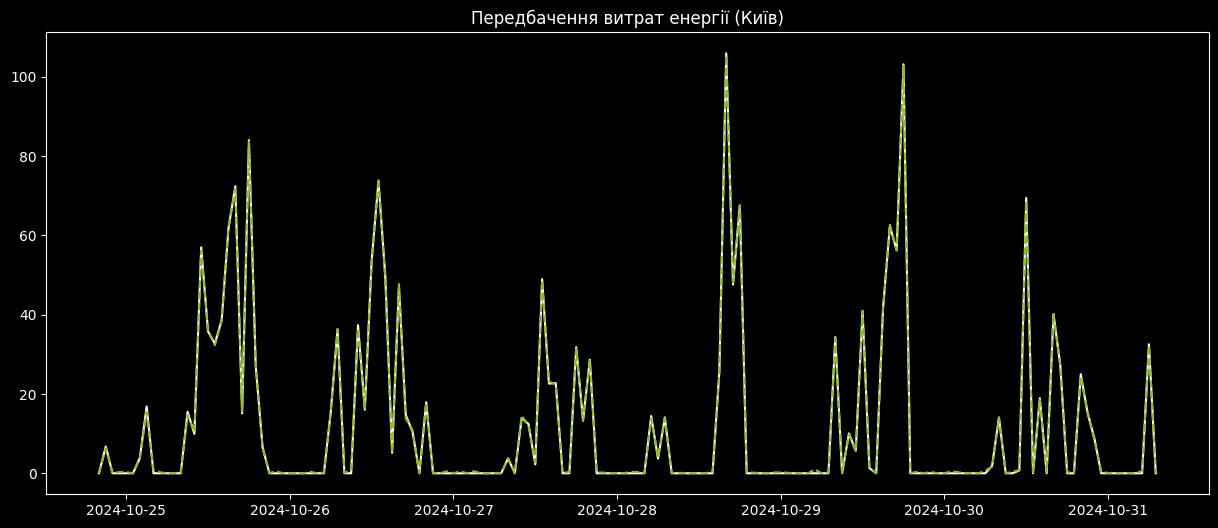

In [145]:
plt.figure(figsize=(15, 6))
plt.title('Передбачення витрат енергії (Київ)')
plt.plot(test_kyiv['time'][-156:], y_test[-156:], color='white')
plt.plot(test_kyiv['time'][-156:], kyiv_preds[-156:], color='#91be1e', linestyle='--')

<font>
<font size = '10'>
<center><b>Львів</b></center></font>

In [146]:
lviv_stations['time'] = pd.to_datetime(lviv_stations['time'])

lviv_stations['year'] = lviv_stations['time'].dt.year
lviv_stations['month'] = lviv_stations['time'].dt.month
lviv_stations['day'] = lviv_stations['time'].dt.day
lviv_stations['day_of_week'] = lviv_stations['time'].dt.weekday
lviv_stations['hour'] = lviv_stations['time'].dt.hour

lviv_stations.tail()

# Filter for test (October 2024)
test_lviv = lviv_stations[(lviv_stations['time'].dt.year == 2024) & (lviv_stations['time'].dt.month == 10)]

# Filter for validation (September 2024)
validation_lviv = lviv_stations[(lviv_stations['time'].dt.year == 2024) & (lviv_stations['time'].dt.month == 9)]

# Filter for train (everything before September 2024)
train_lviv = lviv_stations[lviv_stations['time'] < '2024-09-01']

X_train = train_lviv[features]
y_train = train_lviv[target]

X_valid = validation_lviv[features]
y_valid = validation_lviv[target]

train_lviv = lviv_stations[lviv_stations['time'] > '2023-01-01']
X_train = train_lviv[features]
y_train = train_lviv[target]

C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\3532011575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lviv_stations['time'] = pd.to_datetime(lviv_stations['time'])
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\3532011575.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lviv_stations['year'] = lviv_stations['time'].dt.year
C:\Users\Olena\AppData\Local\Temp\ipykernel_27356\3532011575.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [147]:
# Optimize using Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters
print("Best Parameters:", study.best_params)

# Train the final model using the best parameters
best_params = study.best_params
xgb_model = xgb.XGBRegressor(**best_params, tree_method="auto", n_jobs=4)
xgb_model.fit(X_train, y_train)

# Evaluate the model
final_preds = xgb_model.predict(X_valid)
final_preds = np.clip(final_preds, 0, None)
final_rmse = np.sqrt(mean_squared_error(y_valid, final_preds))
print(f"Optimized XGB RMSE: {final_rmse}")

[I 2024-12-17 23:06:36,845] A new study created in memory with name: no-name-fdedb1c6-8302-44da-bcd5-a8f53d948c17
[I 2024-12-17 23:06:39,328] Trial 0 finished with value: 13.600980005692968 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.10277167194231479, 'subsample': 0.7894168842198979, 'colsample_bytree': 0.5259885549799737, 'gamma': 8.20795965484505, 'lambda': 3.7447605914544564, 'alpha': 0.43844819694383375}. Best is trial 0 with value: 13.600980005692968.
[I 2024-12-17 23:06:41,488] Trial 1 finished with value: 14.396348252130222 and parameters: {'n_estimators': 350, 'max_depth': 3, 'learning_rate': 0.18230868592631247, 'subsample': 0.8950894657862063, 'colsample_bytree': 0.7687133759894484, 'gamma': 7.010165845909054, 'lambda': 0.0010173391723816694, 'alpha': 0.02362344014588206}. Best is trial 0 with value: 13.600980005692968.
[I 2024-12-17 23:06:44,812] Trial 2 finished with value: 13.315168862268013 and parameters: {'n_estimators': 450, 'max_depth': 7

KeyboardInterrupt: 

In [127]:
X_test = test_lviv[features]
y_test = test_lviv[target]

lviv_preds = xgb_model(X_train, X_valid, y_train, y_valid, X_test, y_test)

Test RMSE: 0.1556106718852045


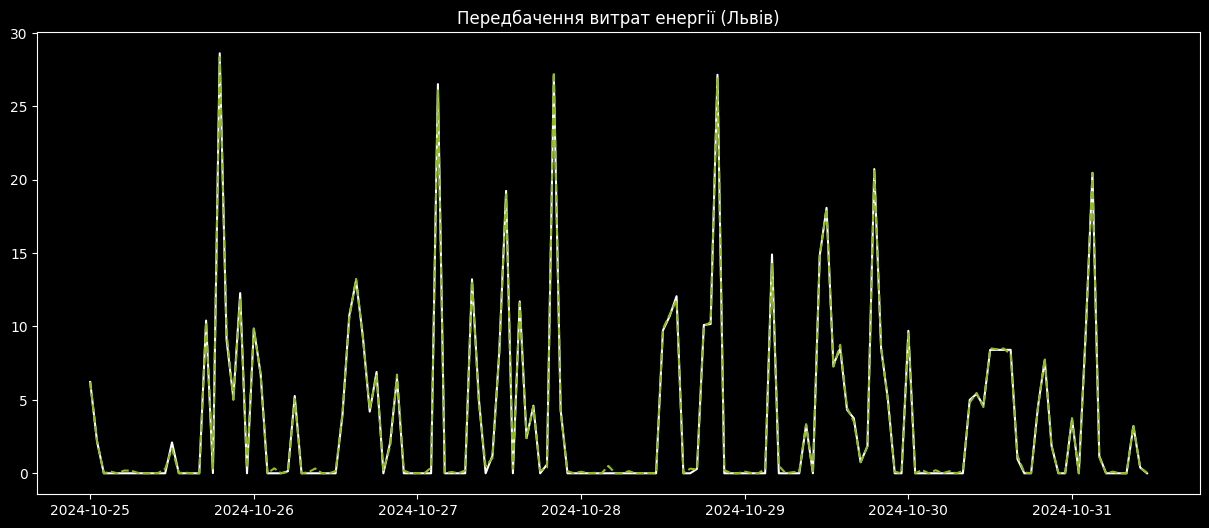

In [128]:
plt.figure(figsize=(15, 6))
plt.title('Передбачення витрат енергії (Львів)')
plt.plot(test_lviv['time'][-156:], y_test[-156:], color='white')
plt.plot(test_lviv['time'][-156:], lviv_preds[-156:], color='#91be1e', linestyle='--')